In [1]:
# External dependencies

import numpy as np
import matplotlib.pyplot as plt
from scipy.special import kv, gamma
from scipy.spatial.distance import cdist
from scipy.linalg import cholesky, cho_solve

# https://scikit-learn.org/stable/auto_examples/gaussian_process/plot_gpr_noisy.html
from sklearn.gaussian_process.kernels import RBF, WhiteKernel

In [145]:
# INPUT DATA

# Sample points for prediction
X = np.linspace(-10, 10, 100).reshape(-1, 1)  # 100 points from -5 to 5

# Observed data points
X_train = np.linspace(-10, 10, 11).reshape(-1, 1)  # 10 training points
#y_train = np.sin(X_train).flatten()  # Example function values at training points
y_train = -np.square(X_train).flatten()  # Example function values at training points

y_train[1] = -100
y_train[2] = -80
y_train[3] = -50
y_train[7] = -40
y_train[8] = -90
y_train[9] = -100

y_train = y_train * 10

# Sample points for prediction
X = np.linspace(-1000, 1000, 100).reshape(-1, 1)  # 100 points from -5 to 5
# Observed data points
X_train = np.linspace(-1000, 1000, 11).reshape(-1, 1)  # 10 training points


[-1000. -1000.  -800.  -500.   -40.    -0.   -40.  -400.  -900. -1000.
 -1000.]


In [3]:
# KERNELS

# RBF kernel function
def rbf_kernel(x1, x2, length_scale, variance):
    sqdist = np.sum((x1 - x2)**2)
    return variance * np.exp(-0.5 * sqdist / length_scale**2)

# Matern kernel function
def matern_kernel(x1, x2, length_scale, nu, variance):
    
    # Calculate the Euclidean distance between points
    d = np.sqrt(np.sum((x1 - x2)**2, axis=-1))
    
    # Special case where nu is large (approximates RBF kernel)
    if nu == np.inf:
        return variance * np.exp(-0.5 * (d / length_scale)**2)
    
    # Compute the Matern kernel
    scaling_factor = 2**(1.0 - nu) / gamma(nu)
    distance_term = np.sqrt(2 * nu) * d / length_scale
    matern_value = scaling_factor * (distance_term**nu) * kv(nu, distance_term)
        
    # Handle the case when distance is zero to avoid NaNs
    matern_value = np.where(d == 0.0, 1, matern_value)
    #matern_value = np.nan_to_num(matern_value, variance)
    
    return variance * matern_value

# Variogram model (spherical)
def variogram(h, range_a, sill, nugget):
    """ Spherical variogram model """
    h = np.abs(h)
    return np.where(h < range_a,
                    nugget + sill * (1.5 * (h / range_a) - 0.5 * (h / range_a)**3),
                    nugget + sill)

In [675]:
# PARAMETERS FOR COVARIANCE MATRIX AND VARIOGRAM

# Noise
noise = 10

# Covariance matrix parameters
length_scale = 500
variance = 500
varaiance_for_title = variance
nu = 1.5 # 1/2 becomes exponential covariance function k(r) = exp(-r/l)
         # 3/2 and 5/2 for ML
         # Carl Edward Rasmussen and Christopher K. I. Williams,
         # Gaussian Processes for Machine Learning,
         # Adaptive Computation and Machine Learning (Cambridge, Mass: MIT Press, 2006), p85.

# Variogram parameters
range_a = length_scale  # Range of the variogram, assumed equal to length scale of covariance matrix kernel
sill = variance  # Sill of the variogram, , assumed equal to variance of covariance matrix kernel
nugget = noise # Nugget effect



In [676]:
# WHITE NOISE GENERATION

WhiteKernel(noise_level=1, noise_level_bounds=(1e-5, 1e1))

WhiteKernel(noise_level=1)

In [677]:
# GAUSSIAN PROCESS EXAMPLE 

# Covariance matrix for the training points
K = np.zeros((len(X_train), len(X_train)))
for i in range(len(X_train)):
    for j in range(len(X_train)):
        K[i, j] = matern_kernel(X_train[i], X_train[j], length_scale, nu, variance)

# Add noise to diagonal of covariance matrix
K = K + np.random.normal(0, noise, len(X_train)) * np.eye(len(X_train))

# Covariance matrix between the training points and the test points
K_s = np.zeros((len(X_train), len(X)))
for i in range(len(X_train)):
    for j in range(len(X)):
        K_s[i, j] = matern_kernel(X_train[i], X[j], length_scale, nu, variance)

# Covariance matrix for the test points
K_ss = np.zeros((len(X), len(X)))
for i in range(len(X)):
    for j in range(len(X)):
        K_ss[i, j] = matern_kernel(X[i], X[j], length_scale, nu, variance)

# Mean and covariance of the conditional distribution
K_inv = np.linalg.inv(K + 1e-8 * np.eye(len(X_train)))  # Add a small noise term for numerical stability

# Mean of the conditioned GP
mu_s = K_s.T.dot(K_inv).dot(y_train)

# Covariance of the conditioned GP
cov_s = K_ss - K_s.T.dot(K_inv).dot(K_s)

# Samples from the conditioned GP
np.random.seed(42)
samples = np.random.multivariate_normal(mu_s, cov_s, 3)  # 3 samples

C:\Users\cco\AppData\Local\Temp\ipykernel_7296\583879295.py:24: RuntimeWarning: invalid value encountered in double_scalars
  matern_value = scaling_factor * (distance_term**nu) * kv(nu, distance_term)
C:\Users\cco\AppData\Local\Temp\ipykernel_7296\1232374528.py:35: RuntimeWarning: covariance is not positive-semidefinite.
  samples = np.random.multivariate_normal(mu_s, cov_s, 3)  # 3 samples


In [678]:
# SEQUENTIAL GAUSSIAN SIMULATION WITH COVARIANCE MATRIX

# Function to perform SGS
def sequential_gaussian_simulation(X_train, y_train, X, kernel, length_scale, variance, num_simulations):
    simulations = np.zeros((num_simulations, len(X)))
    for s in range(num_simulations):
        y_sim = np.zeros(len(X))
        for i, xi in enumerate(X):
            X_all = np.vstack([X_train, X[:i+1]])
            K = np.zeros((len(X_all), len(X_all)))
            for m in range(len(X_all)):
                for n in range(len(X_all)):
                    K[m, n] = kernel(X_all[m], X_all[n], length_scale, variance)
            
            K_train = K[:len(X_train) + i, :len(X_train) + i]
            K_train_inv = np.linalg.inv(K_train + 1e-8 * np.eye(len(K_train)))
            
            K_s = K[:len(X_train) + i, len(X_train) + i:len(X_train) + i + 1]
            K_s = np.round_(K_s, 8)
            K_ss = K[len(X_train) + i:len(X_train) + i + 1, len(X_train) + i:len(X_train) + i + 1]
            
            mu = K_s.T.dot(K_train_inv).dot(np.append(y_train, y_sim[:i]))
            sigma = np.max((K_ss - K_s.T.dot(K_train_inv).dot(K_s), 0))
            #sigma = np.abs(K_ss - K_s.T.dot(K_train_inv).dot(K_s))
            y_sim[i] = np.random.normal(mu, np.sqrt(sigma))
            
        simulations[s, :] = y_sim
    return simulations

# Perform SGS
num_simulations = 5
simulations = sequential_gaussian_simulation(X_train, y_train, X, rbf_kernel, length_scale, variance, num_simulations)


In [679]:
# SEQUENTIAL GAUSSIAN SIMULATION WITH VARIOGRAM

nx = len(X)

# Perform SGS with conditioning data
num_simulations = 3
simulations = np.zeros((num_simulations, nx))

for s in range(num_simulations):
    y_sim = np.zeros(nx)
    for i in range(nx):
        X_all = np.vstack([X_train, X[:i+1]])
        
        # Calculate the covariance matrix using the variogram
        h = cdist(X_all, X_all)
        cov_matrix = sill - variogram(h, range_a, sill, nugget)
        
        # Split the covariance matrix
        cov_11 = cov_matrix[:len(X_train)+i, :len(X_train)+i]
        cov_12 = cov_matrix[:len(X_train)+i, len(X_train)+i:len(X_train)+i+1]
        cov_22 = cov_matrix[len(X_train)+i:len(X_train)+i+1, len(X_train)+i:len(X_train)+i+1]
        
        # Calculate the mean and variance for the new point
        mean = cov_12.T @ np.linalg.pinv(cov_11) @ np.hstack([y_train, y_sim[:i]])
        variance = cov_22 - cov_12.T @ np.linalg.pinv(cov_11) @ cov_12
        
        # Draw a random sample from the normal distribution
        y_sim[i] = np.random.normal(mean, np.sqrt(variance))
    
    simulations[s, :] = y_sim

C:\Users\cco\AppData\Local\Temp\ipykernel_7296\3163751119.py:11: RuntimeWarning: invalid value encountered in sqrt
  plt.fill_between(X.flatten(), mu_s - 1.96 * np.sqrt(np.diag(cov_s)), mu_s + 1.96 * np.sqrt(np.diag(cov_s)), color='gray', alpha=0.2, label='95% Conf. Int.')


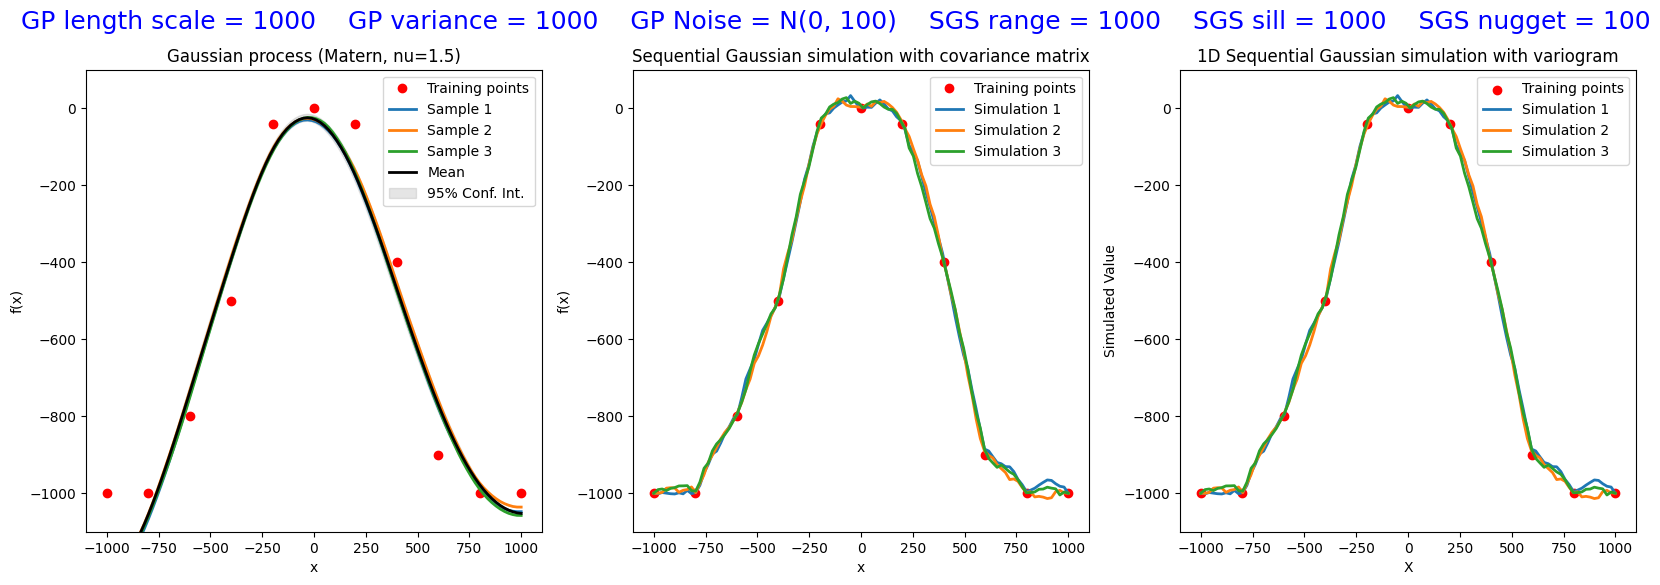

In [680]:
# PLOT GP AND SGSs COMPARISON

plt.figure(figsize=(20, 6))
plt.suptitle(f"GP length scale = {length_scale}    GP variance = {varaiance_for_title}    GP Noise = N(0, {noise})    SGS range = {range_a}    SGS sill = {sill}    SGS nugget = {noise}", fontsize=18, color="blue")

plt.subplot(1, 3, 1)
plt.plot(X_train, y_train, 'ro', label='Training points')
for i in range(3):
    plt.plot(X, samples[i], label=f'Sample {i+1}', lw=2)
plt.plot(X, mu_s, 'k', lw=2, label='Mean')
plt.fill_between(X.flatten(), mu_s - 1.96 * np.sqrt(np.diag(cov_s)), mu_s + 1.96 * np.sqrt(np.diag(cov_s)), color='gray', alpha=0.2, label='95% Conf. Int.')
plt.title('Gaussian process (Matern, nu=1.5)')
plt.xlabel('x')
plt.ylabel('f(x)')
plt.ylim((-1100, 100))
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(X_train, y_train, 'ro', label='Training points')
for i in range(num_simulations):
    plt.plot(X, simulations[i], label=f'Simulation {i+1}', lw=2)
plt.title('Sequential Gaussian simulation with covariance matrix')
plt.xlabel('x')
plt.ylabel('f(x)')
plt.ylim((-1100, 100))
plt.legend()

plt.subplot(1, 3, 3)
plt.scatter(X_train, y_train, c='red', label='Training points')
for i in range(num_simulations):
    plt.plot(X, simulations[i], label=f'Simulation {i+1}', lw=2)
plt.title('1D Sequential Gaussian simulation with variogram')
plt.xlabel('X')
plt.ylabel('Simulated Value')
plt.legend()
#plt.grid(True)
plt.ylim((-1100, 100))

plt.show()


### https://pylops.readthedocs.io/en/stable/tutorials/solvers.html

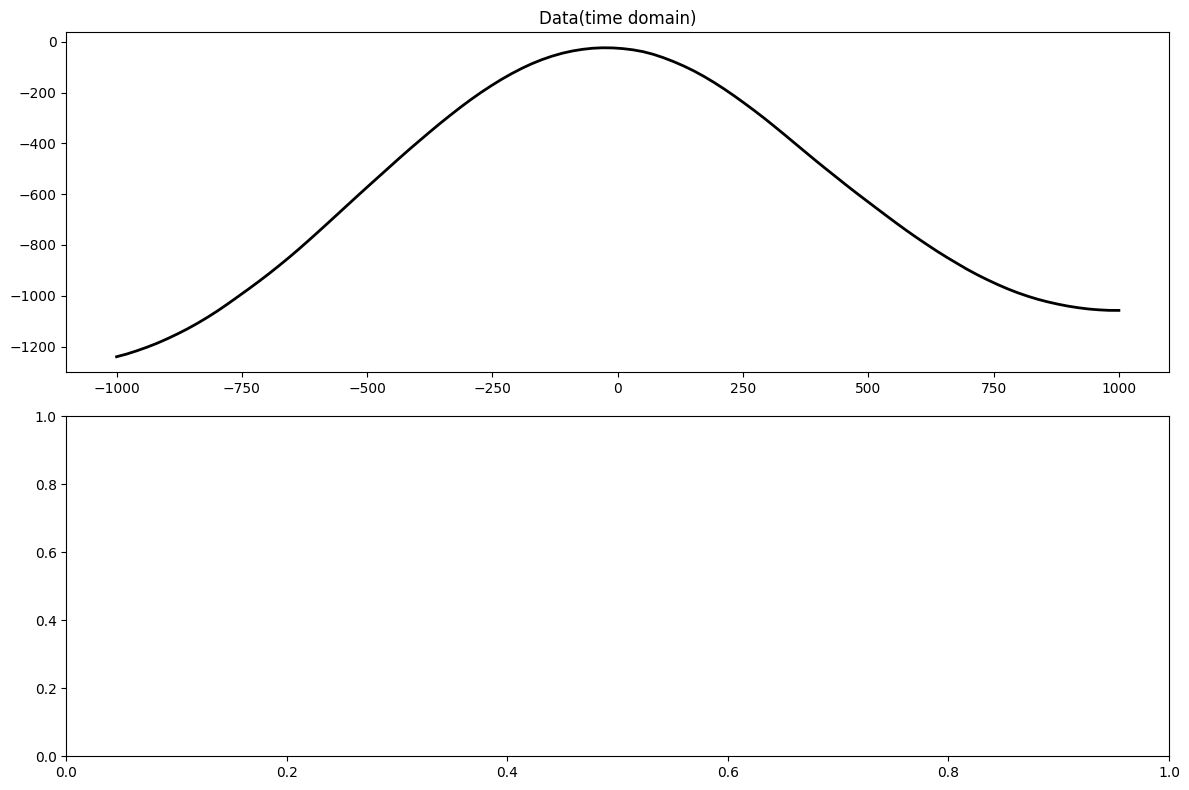

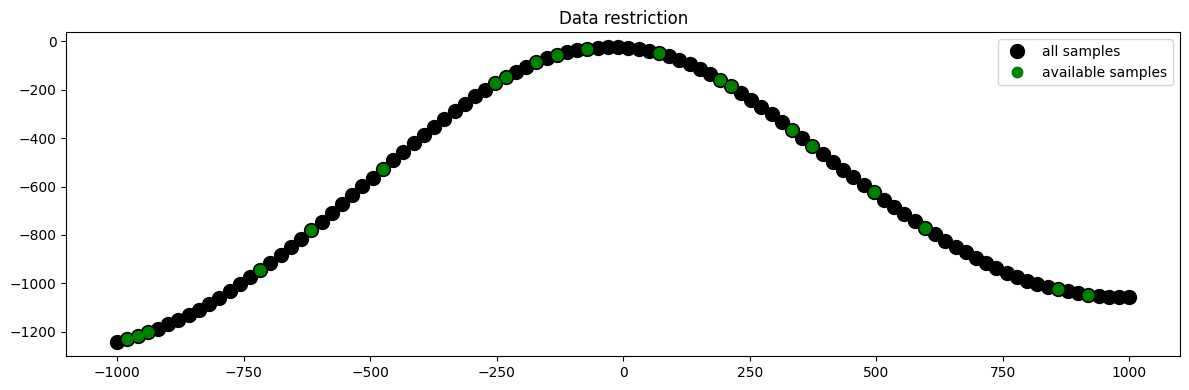

In [681]:
import pylops

plt.close("all")
np.random.seed(10)

t= X
x = samples[2]
N = len(t)

fig, axs = plt.subplots(2, 1, figsize=(12, 8))
axs[0].plot(t, x, "k", lw=2)
axs[0].set_title("Data(time domain)")
axs[0].axis("tight")
plt.tight_layout()

# subsampling locations
perc_subsampling = 0.2
Nsub = int(np.round(N * perc_subsampling))

iava = np.sort(np.random.permutation(np.arange(N))[:Nsub])

# Create restriction operator
Rop = pylops.Restriction(N, iava, dtype="float64")

y = Rop * x
ymask = Rop.mask(x)

# Visualize data
fig = plt.figure(figsize=(12, 4))
plt.plot(t, x, "k", lw=3)
plt.plot(t, x, ".k", ms=20, label="all samples")
plt.plot(t, ymask, ".g", ms=15, label="available samples")
plt.legend()
plt.title("Data restriction")
plt.tight_layout()

In [682]:
# Create regularization operator
D2op = pylops.SecondDerivative(N, dtype="float64")

# Regularized inversion
epsR = np.sqrt(0.1)
epsI = np.sqrt(1e-4)

xne = pylops.optimization.leastsquares.normal_equations_inversion(
    Rop, y, [D2op], epsI=epsI, epsRs=[epsR], **dict(maxiter=50)
)[0]

In [683]:
ND2op = pylops.MatrixMult((D2op.H * D2op).tosparse())  # mimic fast D^T D

xne1 = pylops.optimization.leastsquares.normal_equations_inversion(
    Rop, y, [], NRegs=[ND2op], epsI=epsI, epsNRs=[epsR], **dict(maxiter=50)
)[0]

In [684]:
xreg = pylops.optimization.leastsquares.regularized_inversion(
    Rop,
    y,
    [D2op],
    epsRs=[np.sqrt(0.1)],
    **dict(damp=np.sqrt(1e-4), iter_lim=50, show=0)
)[0]

In [685]:
# Create regularization operator
Sop = pylops.Smoothing1D(nsmooth=11, dims=[N], dtype="float64")

# Invert for interpolated signal
xprec = pylops.optimization.leastsquares.preconditioned_inversion(
    Rop, y, Sop, **dict(damp=np.sqrt(1e-9), iter_lim=20, show=0)
)[0]

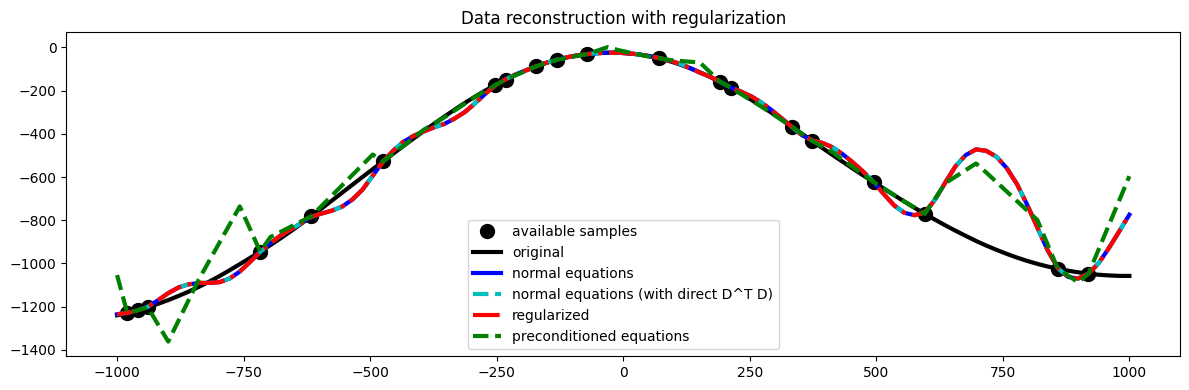

In [686]:
# sphinx_gallery_thumbnail_number=4
fig = plt.figure(figsize=(12, 4))
plt.plot(t[iava], y, ".k", ms=20, label="available samples")
plt.plot(t, x, "k", lw=3, label="original")
plt.plot(t, xne, "b", lw=3, label="normal equations")
plt.plot(t, xne1, "--c", lw=3, label="normal equations (with direct D^T D)")
plt.plot(t, xreg, "-.r", lw=3, label="regularized")
plt.plot(t, xprec, "--g", lw=3, label="preconditioned equations")
plt.legend()
plt.title("Data reconstruction with regularization")

#subax = fig.add_axes([0.7, 0.2, 0.15, 0.6])
#subax.plot(t[iava], y, ".k", ms=20)
#subax.plot(t, x, "k", lw=3)
#subax.plot(t, xne, "b", lw=3)
#subax.plot(t, xne1, "--c", lw=3)
#subax.plot(t, xreg, "-.r", lw=3)
#subax.plot(t, xprec, "--g", lw=3)
#subax.set_xlim(0.05, 0.3)
plt.tight_layout()

### Gaussian Field

In [38]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF

# Grid
x = np.linspace(0, 5, 50)
y = np.linspace(0, 5, 50)
X, Y = np.meshgrid(x, y)
grid_points = np.vstack([X.ravel(), Y.ravel()]).T

# Kernel
length_scale = 1.0
variance = 1.0
kernel = variance * RBF(length_scale=length_scale)

# Generate the Gaussian field
gp = GaussianProcessRegressor(kernel=kernel, random_state=42)
Z = gp.sample_y(grid_points, 1).reshape(X.shape)

In [39]:
# Randomly select 3 points from the previous field
np.random.seed(42)
indices = np.random.choice(len(grid_points), 100, replace=False)
selected_points = grid_points[indices]
selected_values = Z.ravel()[indices]

#print("Selected Points:\n", selected_points)
#print("Selected Values:\n", selected_values)

In [40]:
# Train a Gaussian process with the previous extracted points
gp_small = GaussianProcessRegressor(kernel=kernel, random_state=42)
gp_small.fit(selected_points, selected_values)

# Predict the Gaussian field using the trained Gaussian process
Z_pred, Z_std = gp_small.predict(grid_points, return_std=True)
Z_pred = Z_pred.reshape(X.shape)

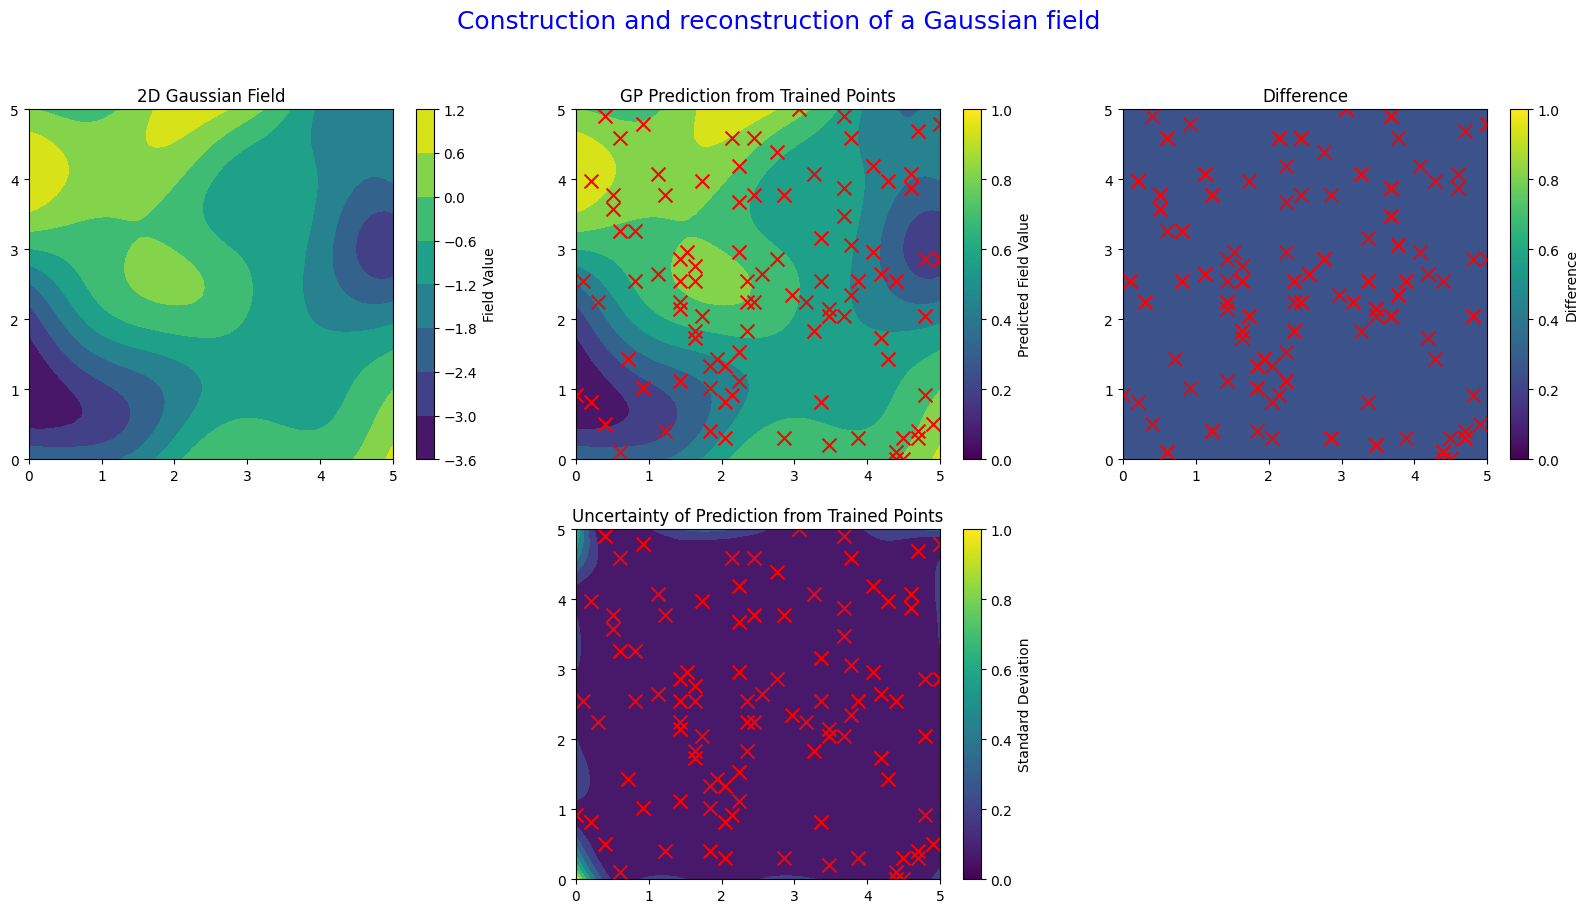

In [43]:
# Plot both original and reconstructed Gaussian fields

plt.figure(figsize=(20, 10))
plt.suptitle(f"Construction and reconstruction of a Gaussian field", fontsize=18, color="blue")

# Original Gaussian field
plt.subplot(2, 3, 1)
plt.contourf(X, Y, Z, cmap='viridis')
plt.title('2D Gaussian Field')
plt.colorbar(label='Field Value')
#plt.clim(-4,4)

# Predicted field
plt.subplot(2, 3, 2)
plt.contourf(X, Y, Z_pred, cmap='viridis')
plt.scatter(selected_points[:, 0], selected_points[:, 1], c='red', marker='x', s=100, label='Selected Points')
plt.title('GP Prediction from Trained Points')
plt.colorbar(label='Predicted Field Value')
#plt.clim(-4,4)

# Standard deviation of predicted field
plt.subplot(2, 3, 5)
plt.contourf(X, Y, Z_std.reshape(X.shape), cmap='viridis')
plt.scatter(selected_points[:, 0], selected_points[:, 1], c='red', marker='x', s=100, label='Selected Points')
plt.title('Uncertainty of Prediction from Trained Points')
plt.colorbar(label='Standard Deviation')

# Difference between original and predicted Gaussian fields
plt.subplot(2, 3, 3)
plt.contourf(X, Y, Z_pred - Z_pred, cmap='viridis')
plt.scatter(selected_points[:, 0], selected_points[:, 1], c='red', marker='x', s=100, label='Selected Points')
plt.title('Difference')
plt.colorbar(label='Difference')
#plt.clim(-4,4)

plt.show()

# Seismic

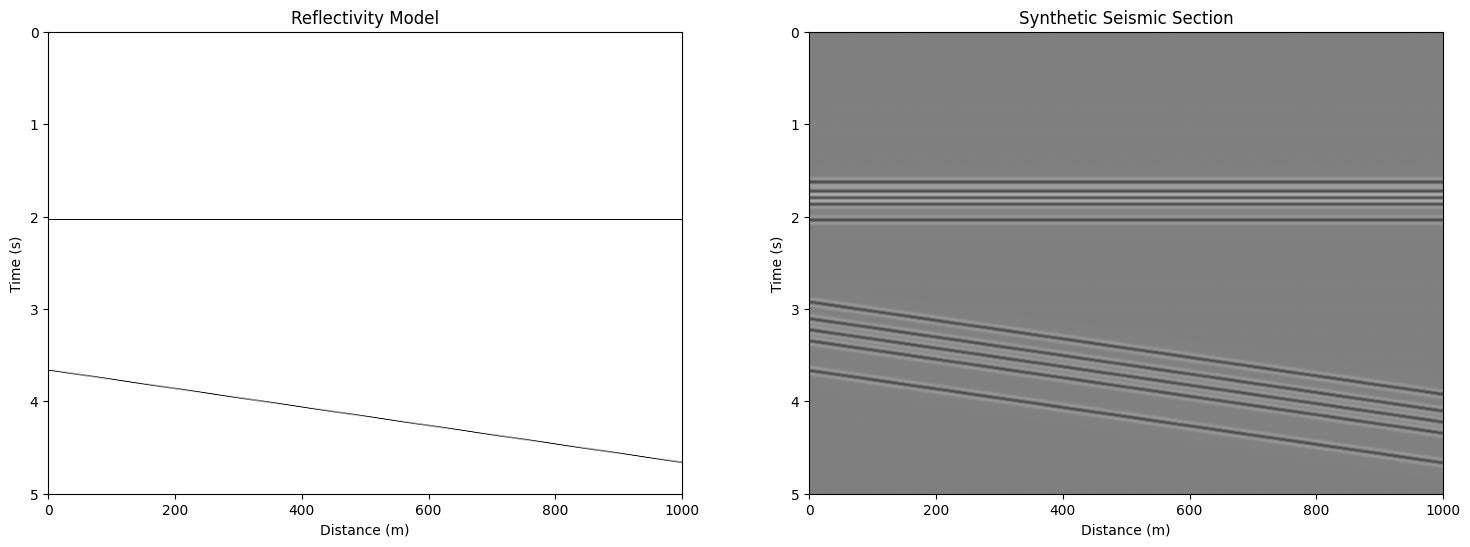

In [117]:
# Import SciPy Ricker wavelet
from scipy.signal import ricker

# Parameters
nt = 500    # Number of time samples
dt = 0.01   # Time sampling in seconds
nz = 100    # Number of traces
dx = 10     # Trace spacing in meters

# Time and depth axis
time = np.arange(nt) * dt
distance = np.arange(nz) * dx

# Initialization of variable to save seismic sections
seismic_realizations=np.zeros((5, nt, nz))
for i in range(5):
    # Velocity model
    v = 1500 + np.random.normal(0, 100) # Velocity in m/s

    # Reflectivity model (2D grid with reflectors)
    reflectivity = np.zeros((nt, nz))

    # Horizontal reflector
    reflector_depth = int(2500 / (v * dt))
    reflectivity[reflector_depth, :] = 0.7  # Reflectivity coefficient

    # Dipping reflector
    slope = 1  # Slope of the dipping reflector
    intercept_depth = int(4500 / (v * dt))
    for ix in range(nz):
        depth_idx = intercept_depth + int(ix * slope)
        if depth_idx < nt:  # Ensure we don't go out of bounds
            reflectivity[depth_idx, ix] = 0.7  # Reflectivity coefficient

    # Ricker wavelet from SciPy
    f0 = 20  # Dominant frequency of the Ricker wavelet in Hz
    wavelet = ricker(nt/10, f0 * dt * 10)

    # Convolution of wavelet with reflectivity model to get each trace
    seismic = np.apply_along_axis(lambda trace: np.convolve(trace, wavelet, mode='same'), axis=0, arr=reflectivity)

    # Add noise
    noise = 0.0 * np.random.randn(nt, nz)

    # Save each seismic section in a different variable
    seismic_realizations[i] = seismic + noise


# Plots
plt.figure(figsize=(18, 6))

# Plot of Reflectivity Model
plt.subplot(1, 2, 1)
plt.imshow(reflectivity, cmap='gray_r', aspect='auto', extent=[0, nz * dx, nt * dt, 0])
plt.title('Reflectivity Model')
plt.xlabel('Distance (m)')
plt.ylabel('Time (s)')

# Plot of Seismic Section
plt.subplot(1, 2, 2)
plt.imshow(np.sum(seismic_realizations, axis=0), cmap='gray_r', aspect='auto', extent=[0, nz * dx, nt * dt, 0], vmin=-1, vmax=1)
plt.title('Synthetic Seismic Section')
plt.xlabel('Distance (m)')
plt.ylabel('Time (s)')
plt.show()



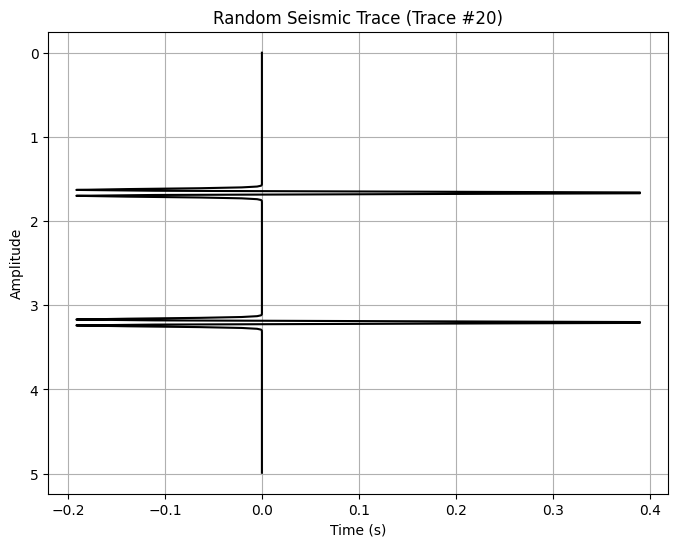

In [118]:
# Plot of a trace for QC

# Select random trace index
random_trace_index = np.random.randint(0, nz)

# Select random trace
random_trace = seismic_noisy[:, random_trace_index]

# Plot selected trace
plt.figure(figsize=(8, 6))
plt.plot(random_trace, time, color='black')
plt.gca().invert_yaxis()  # Invert y-axis to mimic seismic display
plt.title(f'Random Seismic Trace (Trace #{random_trace_index})')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.grid(True)
plt.show()